# Download and import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
! git clone https://github.com/aaron-xichen/pytorch-playground.git
# ! pip install utee

fatal: destination path 'pytorch-playground' already exists and is not an empty directory.


In [3]:
#### Install libraries ############
% cd pytorch-playground
# ! ls
! python3 setup.py develop --user
# ! pip install anaconda
# ! pip install torch==1.8.1 torchvision
# ! pip install tqdm
# ! pip install numpy
# ! pip install utee
#! pip uninstall pytorch-playground
# ! pip install --upgrade torchvision
! pip install -U scikit-learn

/content/drive/MyDrive/pytorch-playground
running develop
running egg_info
writing pytorch_playground.egg-info/PKG-INFO
writing dependency_links to pytorch_playground.egg-info/dependency_links.txt
writing entry points to pytorch_playground.egg-info/entry_points.txt
writing requirements to pytorch_playground.egg-info/requires.txt
writing top-level names to pytorch_playground.egg-info/top_level.txt
reading manifest file 'pytorch_playground.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'pytorch_playground.egg-info/SOURCES.txt'
running build_ext
Creating /root/.local/lib/python3.7/site-packages/pytorch-playground.egg-link (link to .)
Adding pytorch-playground 1.0.0 to easy-install.pth file
Installing quantize script to /root/.local/bin

Installed /content/drive/MyDrive/pytorch-playground
Processing dependencies for pytorch-playground==1.0.0
Searching for joblib==0.14.1
Reading https://pypi.org/simple/joblib/
Best match: joblib 0.14.1
Processing joblib-0.14.1-py2

In [4]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image

# Values

In [7]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
print(DEVICE)
batch_size = 100

cuda


# Define adversarial classes and target classifier network

In [8]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return X + epsilon * delta.grad.detach().sign()

def fgsm_L2(model, X, y, epsilon):
    """ Construct FGSM-L2 adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return X + epsilon * delta.grad.detach()/torch.norm(torch.norm((delta.grad.detach()),dim=2,keepdim=True),dim=3,keepdim=True)

def R_fgsm(model, X, y, epsilon, alpha):
    """ Construct R-FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    return fgsm(model, random(X,alpha),y,epsilon)

def R_fgsm_L2(model, X, y, epsilon, alpha):
    """ Construct R-FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    return fgsm_L2(model, random(X,alpha), y, epsilon)

def random(X, epsilon) :
    delta = 2*torch.rand_like(X).to(DEVICE) - 1
    return torch.clip(X + epsilon*delta,0.,1.)

def BIM(model, X, y, epsilon, epsilon_step, no_of_steps):
    """ Construct BIM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    Xi = X.clone()
    for i in range(no_of_steps) :
      # delta = torch.zeros_like(X, requires_grad=True)
      loss = nn.CrossEntropyLoss()(model(X + delta), y)
      loss.backward()
      X = torch.clip(X.clone() + epsilon_step * delta.grad.detach().sign(),-1.,1.)
    diff = X - Xi
    return Xi + torch.clip(diff,-epsilon,epsilon)

def BIM_L2(model, X, y, epsilon, epsilon_step, no_of_steps):
    """ Construct BIM-L2 adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    Xi = X.clone()
    for i in range(no_of_steps) :
      loss = nn.CrossEntropyLoss()(model(X + delta), y)
      loss.backward()
      X = torch.clip(X.clone() + epsilon_step * (delta.grad.detach())/torch.norm((delta.grad.detach()),dim=1,keepdim=True),-1.,1.)
    diff = X - Xi
    factor = torch.clip(torch.norm(torch.norm((diff.detach()),dim=2,keepdim=True),\
              dim=3,keepdim=True),0,epsilon)\
              / torch.norm(torch.norm((diff.detach()),dim=2,keepdim=True),\
              dim=3,keepdim=True)
    return Xi + diff*factor

def CW(model,X,y,epsilon,epsilon_step,no_of_steps,c,target):
    """ Construct CW adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    Xn = X.clone()
    # Iterations
    for i in range(no_of_steps) :
      sec_target = []
      A = model(Xn+delta)
      for i in range(A.shape[0]) :
        maxi = -1
        maxval = -10000
        for j in range(A.shape[1]) :
          if A[i,j] > maxval and j!=target[i]:
            maxval = A[i,j]
            maxi = j
        sec_target.append(maxi)
      
      val = torch.diag(A[:,target[:]])
      val_targ = torch.diag(A[:,sec_target[:]])
      # print(val)
      # print(val_targ)
      # for i in range(A.shape[0]) :  
      #   A[i,target[i]] = -1000
      loss = -torch.mean((Xn+delta-X)**2) - torch.mean(c*torch.clip(val_targ-val,-4,1000))
      loss.backward()
      Xn = Xn.clone() + epsilon_step * delta.grad.detach()
    diff = Xn - X
    return X + torch.clip(diff,-epsilon,epsilon) 

def S_BIM(model,model_detector,X,target,epsilon,sigma,epsilon_step,no_of_steps):
    """ Construct S-BIM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    delta_detector = torch.zeros_like(X, requires_grad=True)
    Xn = X.clone()
    for i in range(no_of_steps) :
      sec_target = []
      A = model(Xn+delta)
      for i in range(A.shape[0]) :
        maxi = -1
        maxval = -10000
        for j in range(A.shape[1]) :
          if A[i,j] > maxval and j!=target[i]:
            maxval = A[i,j]
            maxi = j
        sec_target.append(maxi)
      
      val = torch.diag(A[:,target[:]])
      val_targ = torch.diag(A[:,sec_target[:]])
      loss = -sigma*torch.mean((Xn+delta-get_recon(model_detector,Xn+delta,target))**2) - (1-sigma)*torch.mean(torch.clip(val_targ-val,-4,1000))
      loss.backward()
      Xn = Xn.clone() + epsilon_step * delta.grad.detach().sign()
    diff = Xn - X
    return X + torch.clip(diff,-epsilon,epsilon) 


from torch.autograd import Variable
from utee import selector
model_raw, ds_fetcher, is_imagenet = selector.select('cifar10')

Building and initializing cifar10 parameters
Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), paddi

# Download and preprocess dataset

In [9]:
from torchvision.datasets import MNIST,CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {} 
class AugDataset(Dataset):
  def __init__(self,orig_dataset):
    self.dataset = orig_dataset
  
  def __len__(self):
    return 4*self.dataset.__len__()
  
  def __getitem__(self,idx):
    if idx<self.dataset.__len__() :
      return self.dataset.__getitem__(idx)
    
    idx = idx-self.dataset.__len__()
    if idx<self.dataset.__len__() :
      x_in,y = self.dataset.__getitem__(idx)
      x_in = x_in.view(1,x_dim)
      x_in = x_in.to(DEVICE)
      y = torch.tensor(y).unsqueeze(0)
      y = y.to(DEVICE)
      x_out = Ifgsm(model_raw,x_in,y,0.02,5)
      y = 12
      x_out = x_out.view(1,28,28).cpu()
      return x_out, y
    
    idx = idx-self.dataset.__len__()
    if idx<self.dataset.__len__() :
      x_in,y = self.dataset.__getitem__(idx)
      x_in = x_in.view(1,x_dim)
      x_in = x_in.to(DEVICE)
      y = torch.tensor(y).unsqueeze(0)
      y = y.to(DEVICE)
      x_out = Rfgsm(model_raw,x_in,y,0.1,0.01)
      y = 11
      x_out = x_out.view(1,28,28).cpu()
      return x_out, y
    
    idx = idx-self.dataset.__len__()
    if idx<self.dataset.__len__() :
      x_in,y = self.dataset.__getitem__(idx)
      x_in = x_in.view(1,x_dim)
      x_in = x_in.to(DEVICE)
      y = torch.tensor(y).unsqueeze(0)
      y = y.to(DEVICE)
      x_out = fgsm(model_raw,x_in,y,0.1)
      y = 10
      x_out = x_out.view(1,28,28).cpu()
      return x_out, y

def get_same_index(target, label):
    label_indices = []
    for i in range(len(target)):
        if target[i] == label:
            label_indices.append(i)
    return label_indices

train_dataset_raw = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset_raw  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)
print(len(test_dataset_raw))
# train_dataset_raw = train_dataset_raw[:30000]
train_dataset = AugDataset(train_dataset_raw)
test_dataset = AugDataset(test_dataset_raw)
print(len(train_dataset_raw))
train_loader = DataLoader(dataset=train_dataset_raw, batch_size=batch_size, shuffle=True, **kwargs)
test_loader1  = DataLoader(dataset=test_dataset_raw,  batch_size=batch_size, shuffle=True,  **kwargs)
label_class = 1# birds

# Get indices of label_class
train_indices = get_same_index(train_dataset_raw, label_class)

bird_set = torch.utils.data.Subset(train_dataset_raw, train_indices)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/datasets/cifar-10-python.tar.gz to /root/datasets
Files already downloaded and verified
10000
50000


# Conditional VAE

# Hyperparameters

In [10]:
seed=0
epochs=50
batch_size=16
learning_rate=0.01
latent_size=128
print_every=100
device = 'cuda'
conditional = True
n_labels = 10

def idx2onehot(idx, n):
    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    return onehot

# Define VAE_conv model

In [30]:
class VAE_conv(nn.Module):
    def __init__(self, label, image_size, channel_num, kernel_num, z_size, conditional=False,n_labels=0):
        # configurations
        super().__init__()
        self.label = label
        self.image_size = image_size
        self.channel_num = channel_num
        self.kernel_num = kernel_num
        self.z_size = z_size

        # encoder
        self.encoder = nn.Sequential(
            self._conv(channel_num, kernel_num // 4),
            self._conv(kernel_num // 4, kernel_num // 2),
            self._conv(kernel_num // 2, kernel_num, last=True),
        )

        # encoded feature's size and volume
        self.feature_size = image_size // 8
        self.feature_volume = kernel_num * (self.feature_size ** 2)
        self.conditional = conditional
        if self.conditional:
            # q
            self.q_mean = self._linear(self.feature_volume+n_labels, z_size, relu=False)
            self.q_logvar = self._linear(self.feature_volume+n_labels, z_size, relu=False)
            print(z_size+n_labels)
            self.project = self._linear(z_size+n_labels, self.feature_volume, relu=False)
        else :
            # q
            self.q_mean = self._linear(self.feature_volume, z_size, relu=False)
            self.q_logvar = self._linear(self.feature_volume, z_size, relu=False)
            self.project = self._linear(z_size, self.feature_volume, relu=False)

        # decoder
        self.decoder = nn.Sequential(
            self._deconv(kernel_num, kernel_num // 2),
            self._deconv(kernel_num // 2, kernel_num // 4),
            self._deconv(kernel_num // 4, channel_num, last=True),
            nn.Sigmoid()
        )

    def forward(self, x, c=None):
        # encode x
        encoded = self.encoder(x)
        if self.conditional:
            c = idx2onehot(c, n=n_labels)
            # encoded = torch.cat((encoded, c), dim=-1)
        # sample latent code z from q given x.
        mean, logvar = self.q(encoded,c)
        z = self.z(mean, logvar)
        if self.conditional:
            # c = idx2onehot(c, n=n_labels)
            z = torch.cat((z, c), dim=-1)
        
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )

        # reconstruct x from z
        x_reconstructed = self.decoder(z_projected)

        # return the parameters of distribution of q given x and the
        # reconstructed image.
        return x_reconstructed, mean, logvar, z
    
    def inference(self, z, c=None):
        # c = idx2onehot(c, n=n_labels)
        # z = torch.cat((z, c), dim=-1)
        # print(z.shape)
        # print(self.conditional)
        z_projected = self.project(z)
        z_projected = z_projected.view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )
        recon_x = self.decoder(z_projected)
        return recon_x
    # ==============
    # VAE components
    # ==============

    def q(self, encoded,c=None):
        if c is None :
          unrolled = encoded.view(-1, self.feature_volume)
        else :
          unrolled = encoded.view(-1, self.feature_volume)
          unrolled = torch.cat((unrolled, c), dim=-1)

        return self.q_mean(unrolled), self.q_logvar(unrolled)

    def z(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = (
            Variable(torch.randn(std.size())).cuda() if self._is_on_cuda else
            Variable(torch.randn(std.size()))
        )
        return eps.mul(std).add_(mean)

    def reconstruction_loss(self, x_reconstructed, x):
        return nn.BCELoss(size_average=False)(x_reconstructed, x) / x.size(0)

    def kl_divergence_loss(self, mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar) / 2).sum() / mean.size(0)

    # =====
    # Utils
    # =====

    @property
    def name(self):
        return (
            'VAE'
            '-{kernel_num}k'
            '-{label}'
            '-{channel_num}x{image_size}x{image_size}'
        ).format(
            label=self.label,
            kernel_num=self.kernel_num,
            image_size=self.image_size,
            channel_num=self.channel_num,
        )

    def sample(self, size):
        z = Variable(
            torch.randn(size, self.z_size).cuda() if self._is_on_cuda() else
            torch.randn(size, self.z_size)
        )
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )
        return self.decoder(z_projected).data

    def _is_on_cuda(self):
        return next(self.parameters()).is_cuda

    # ======
    # Layers
    # ======

    def _conv(self, channel_size, kernel_num, last=False):
        conv = nn.Conv2d(
                channel_size, kernel_num,
                kernel_size=3, stride=2, padding=1,
        )
        return conv if last else nn.Sequential(
            conv,
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _deconv(self, channel_num, kernel_num, last=False):
        deconv = nn.ConvTranspose2d(
            channel_num, kernel_num,
            kernel_size=4, stride=2, padding=1,
        )
        return deconv if last else nn.Sequential(
            deconv,
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _linear(self, in_size, out_size, relu=True):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU(),
        ) if relu else nn.Linear(in_size, out_size)

# Define VAE_conv2 model

In [28]:
class VAE_conv(nn.Module):
    def __init__(self, label, image_size, channel_num, kernel_num, z_size, conditional=False,n_labels=0):
        # configurations
        super().__init__()
        self.label = label
        self.image_size = image_size
        self.channel_num = channel_num
        self.kernel_num = kernel_num
        self.z_size = z_size

        # encoder
        self.encoder = nn.Sequential(
            self._convdash(channel_num, 3),
            self._conv(3, 32),
            self._convdash(32, 32),
            self._convdash(32, 32)
        )

        # encoded feature's size and volume
        self.feature_size = image_size // 8
        self.feature_volume = kernel_num * (self.feature_size ** 2)
        self.conditional = conditional
        if self.conditional:
            # q
            self.q_mean = self._linear(self.feature_volume+n_labels, z_size, relu=False)
            self.q_logvar = self._linear(self.feature_volume+n_labels, z_size, relu=False)
            print(z_size+n_labels)
            self.project = self._linear(z_size+n_labels, self.feature_volume, relu=False)
        else :
            # q
            self.q_mean = self._linear(8192, z_size, relu=False)
            self.q_logvar = self._linear(8192, z_size, relu=False)
            self.project = self._linear(z_size, 8192, relu=False)

        # decoder
        self.decoder = nn.Sequential(
            self._deconvdash(32, 32),
            self._deconvdash(32, 32),
            self._deconv(32, 32),
            self._deconvdash(32, 3, last=True),
            nn.Sigmoid()
        )

    def forward(self, x, c=None):
        # encode x
        encoded = self.encoder(x)
        if self.conditional:
            c = idx2onehot(c, n=n_labels)
            # encoded = torch.cat((encoded, c), dim=-1)
        # sample latent code z from q given x.
        mean, logvar = self.q(encoded,c)
        z = self.z(mean, logvar)
        if self.conditional:
            # c = idx2onehot(c, n=n_labels)
            z = torch.cat((z, c), dim=-1)
        
        z_projected = self.project(z).view(
            -1, 32,
            16,
            16,
        )
        # print(z_projected.shape)
        # reconstruct x from z
        x_reconstructed = self.decoder(z_projected)

        # return the parameters of distribution of q given x and the
        # reconstructed image.
        return x_reconstructed, mean, logvar, z
    
    def inference(self, z, c=None):
        # c = idx2onehot(c, n=n_labels)
        # z = torch.cat((z, c), dim=-1)
        # print(z.shape)
        # print(self.conditional)
        z_projected = self.project(z)
        z_projected = z_projected.view(
            -1, 32,
            16,
            16,
        )
        recon_x = self.decoder(z_projected)
        return recon_x
    # ==============
    # VAE components
    # ==============

    def q(self, encoded,c=None):
        if c is None :
          unrolled = encoded.view(-1, self.feature_volume)
        else :
          unrolled = encoded.view(-1, self.feature_volume)
          unrolled = torch.cat((unrolled, c), dim=-1)

        return self.q_mean(unrolled), self.q_logvar(unrolled)

    def z(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = (
            Variable(torch.randn(std.size())).cuda() if self._is_on_cuda else
            Variable(torch.randn(std.size()))
        )
        return eps.mul(std).add_(mean)

    def reconstruction_loss(self, x_reconstructed, x):
        return nn.BCELoss(size_average=False)(x_reconstructed, x) / x.size(0)

    def kl_divergence_loss(self, mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar) / 2).sum() / mean.size(0)

    # =====
    # Utils
    # =====

    @property
    def name(self):
        return (
            'VAE'
            '-{kernel_num}k'
            '-{label}'
            '-{channel_num}x{image_size}x{image_size}'
        ).format(
            label=self.label,
            kernel_num=self.kernel_num,
            image_size=self.image_size,
            channel_num=self.channel_num,
        )

    def sample(self, size):
        z = Variable(
            torch.randn(size, self.z_size).cuda() if self._is_on_cuda() else
            torch.randn(size, self.z_size)
        )
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )
        return self.decoder(z_projected).data

    def _is_on_cuda(self):
        return next(self.parameters()).is_cuda

    # ======
    # Layers
    # ======

    def _conv(self, channel_size, kernel_num, last=False):
        conv = nn.Conv2d(
                channel_size, kernel_num,
                kernel_size=3, stride=2, padding=1,
        )
        return conv if last else nn.Sequential(
            conv,
            # nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _convdash(self, channel_size, kernel_num, last=False):
        conv = nn.Conv2d(
                channel_size, kernel_num,
                kernel_size=3, stride=1, padding=1,
        )
        return conv if last else nn.Sequential(
            conv,
            # nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _deconv(self, channel_num, kernel_num, last=False):
        deconv = nn.ConvTranspose2d(
            channel_num, kernel_num,
            kernel_size=4, stride=2, padding=1,
        )
        return deconv if last else nn.Sequential(
            deconv,
            # nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )
    def _deconvdash(self, channel_num, kernel_num, last=False):
        deconv = nn.ConvTranspose2d(
            channel_num, kernel_num,
            kernel_size=3, stride=1, padding=1,
        )
        return deconv if last else nn.Sequential(
            deconv,
            # nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )
    def _linear(self, in_size, out_size, relu=True):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU(),
        ) if relu else nn.Linear(in_size, out_size)

# Training

/content/drive/MyDrive
Epoch 00/50 Batch 0000/624, Loss 2285.6926


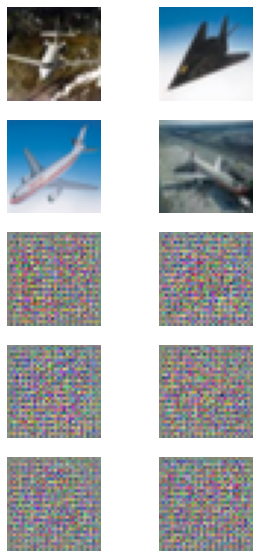

Epoch 01/50 Batch 0000/624, Loss 1874.5305


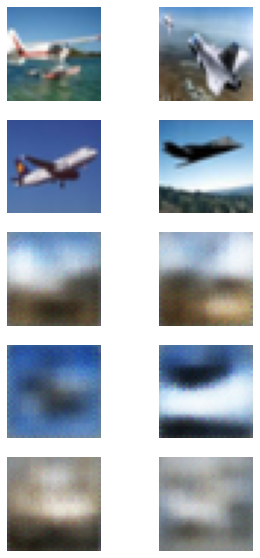

Epoch 02/50 Batch 0000/624, Loss 1926.2527


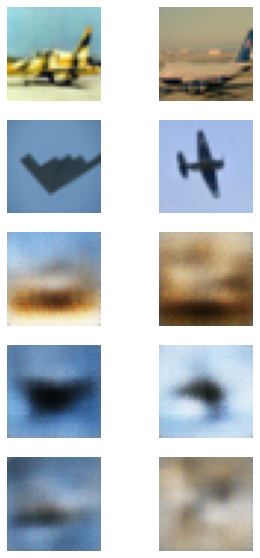

Epoch 03/50 Batch 0000/624, Loss 1856.5116


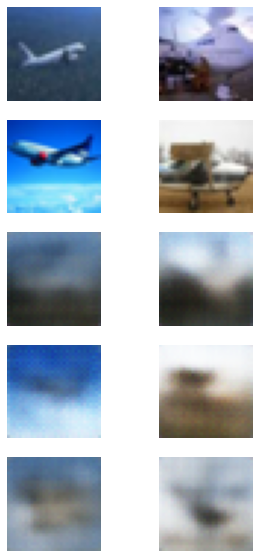

Epoch 04/50 Batch 0000/624, Loss 1828.8221


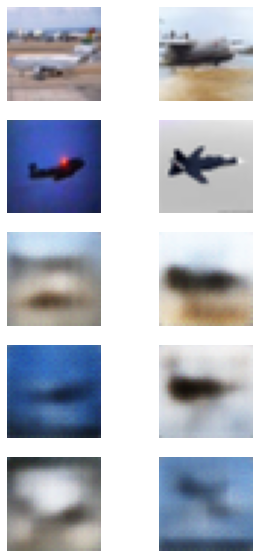

Epoch 05/50 Batch 0000/624, Loss 1807.3773


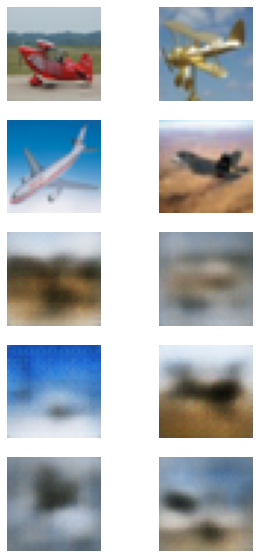

Epoch 06/50 Batch 0000/624, Loss 1776.8756


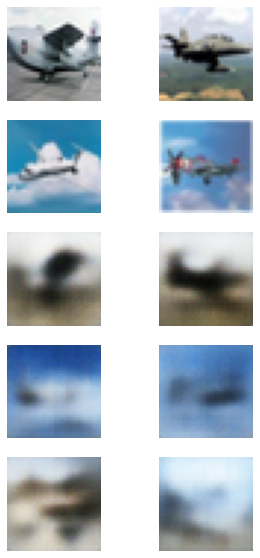

Epoch 07/50 Batch 0000/624, Loss 1777.9172


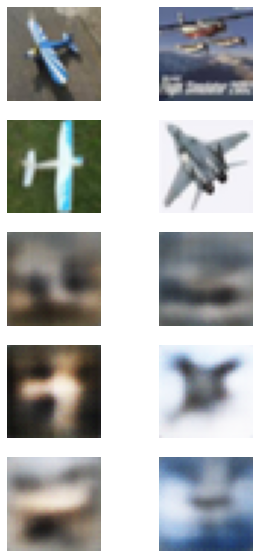

Epoch 08/50 Batch 0000/624, Loss 1794.2788


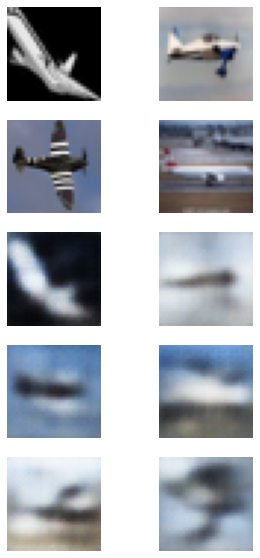

Epoch 09/50 Batch 0000/624, Loss 1709.5723


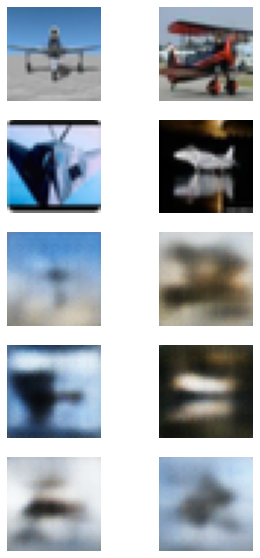

Epoch 10/50 Batch 0000/624, Loss 1907.3180


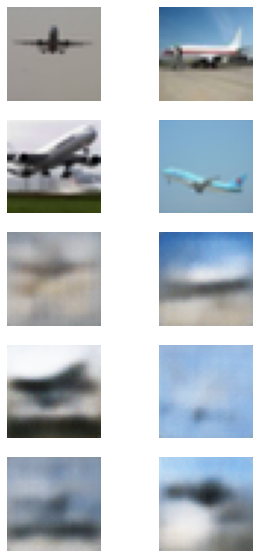

Epoch 11/50 Batch 0000/624, Loss 1687.6899


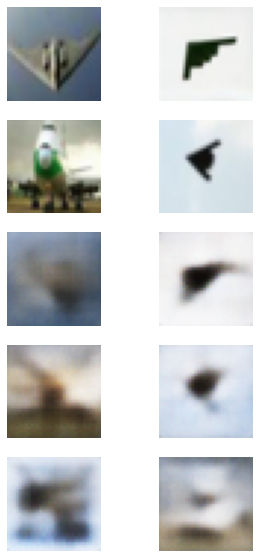

Epoch 12/50 Batch 0000/624, Loss 1738.0398


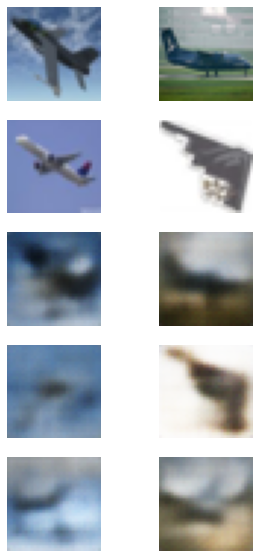

Epoch 13/50 Batch 0000/624, Loss 1713.1847


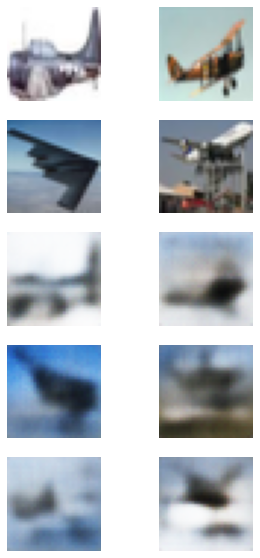

Epoch 14/50 Batch 0000/624, Loss 1877.9987


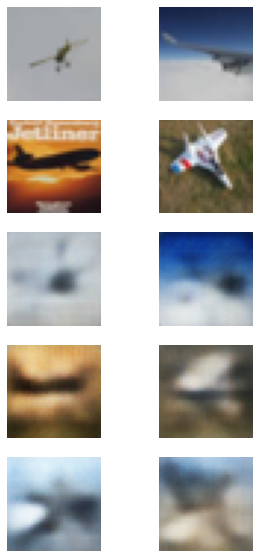

Epoch 15/50 Batch 0000/624, Loss 1766.2332


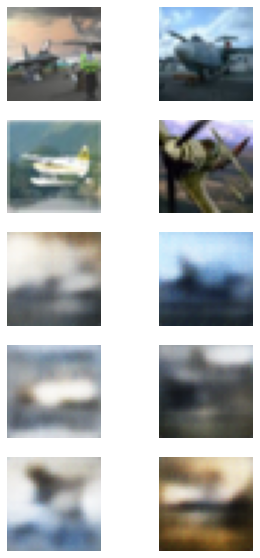

Epoch 16/50 Batch 0000/624, Loss 1816.3207


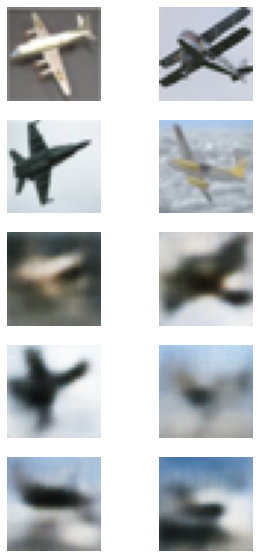

Epoch 17/50 Batch 0000/624, Loss 1717.7212


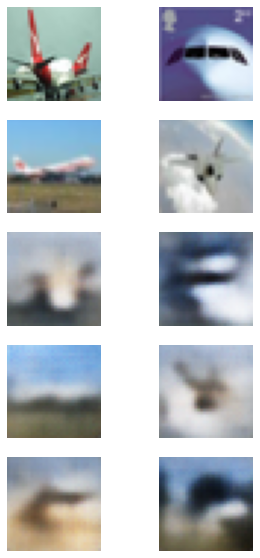

Epoch 18/50 Batch 0000/624, Loss 1723.3744


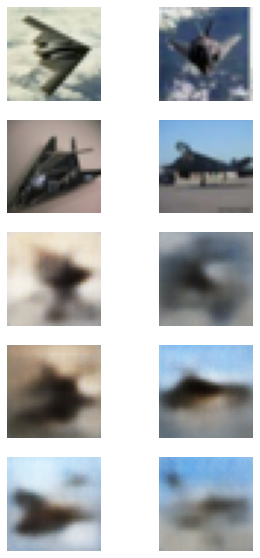

Epoch 19/50 Batch 0000/624, Loss 1824.6641


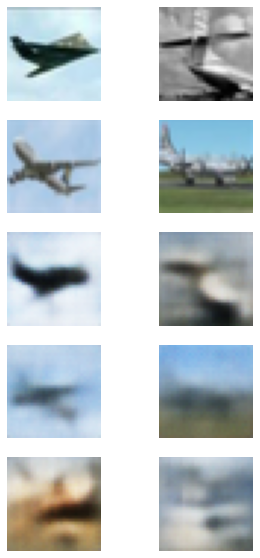

Epoch 20/50 Batch 0000/624, Loss 1760.8802


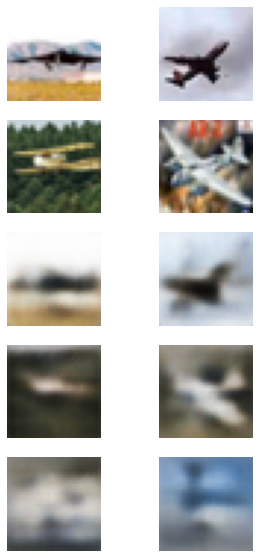

Epoch 21/50 Batch 0000/624, Loss 1721.2118


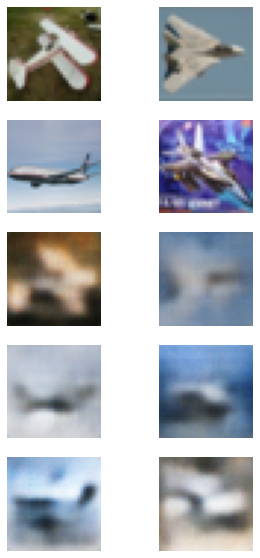

Epoch 22/50 Batch 0000/624, Loss 1821.3501


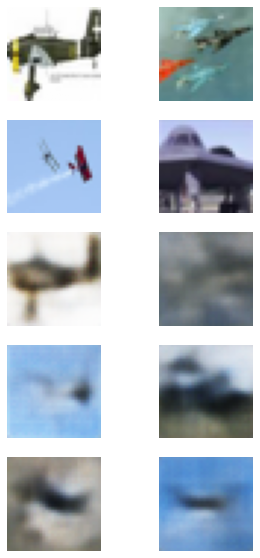

Epoch 23/50 Batch 0000/624, Loss 1827.3810


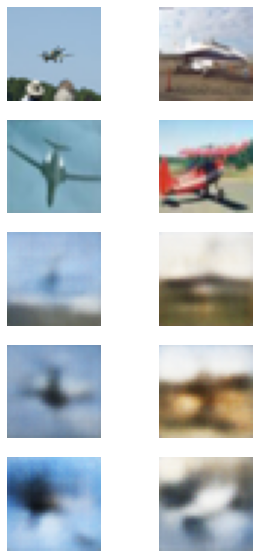

Epoch 24/50 Batch 0000/624, Loss 1688.8369


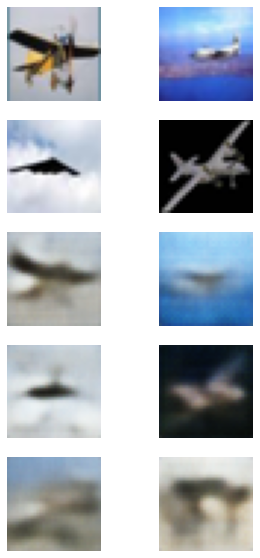

Epoch 25/50 Batch 0000/624, Loss 1812.0793


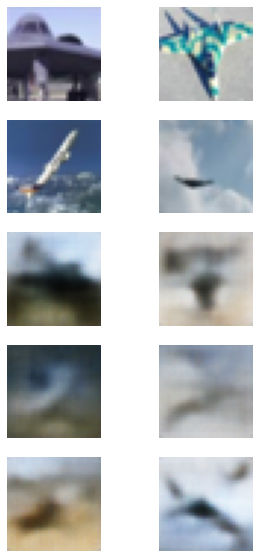

Epoch 26/50 Batch 0000/624, Loss 1707.8389


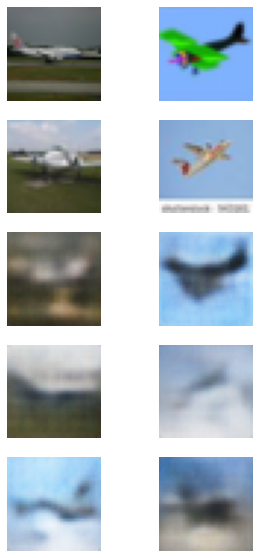

Epoch 27/50 Batch 0000/624, Loss 1857.9041


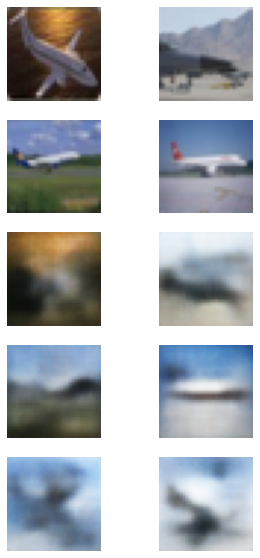

Epoch 28/50 Batch 0000/624, Loss 1690.5369


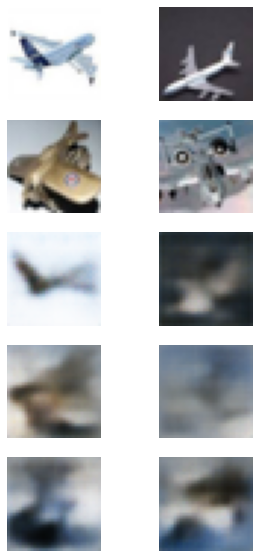

Epoch 29/50 Batch 0000/624, Loss 1739.3354


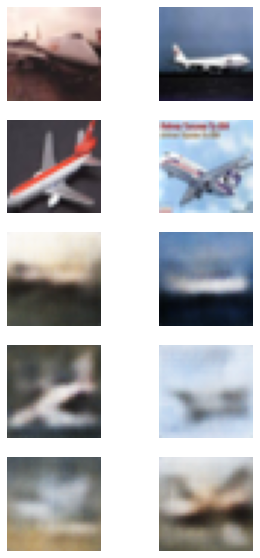

Epoch 30/50 Batch 0000/624, Loss 1698.4044


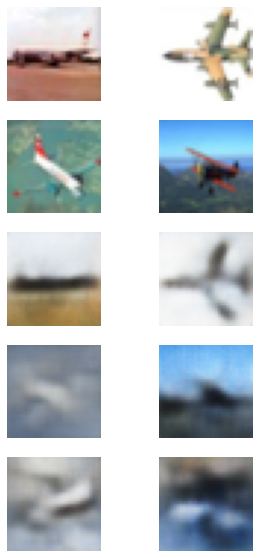

Epoch 31/50 Batch 0000/624, Loss 1817.5786


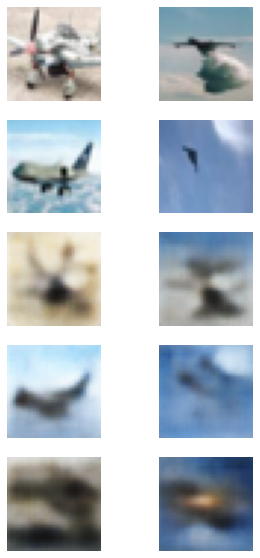

Epoch 32/50 Batch 0000/624, Loss 1771.4628


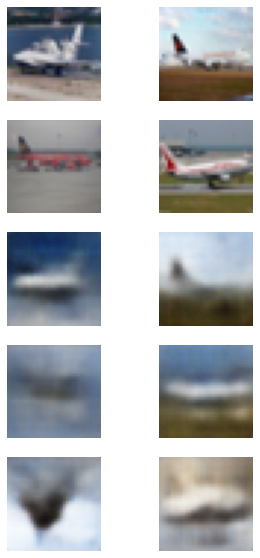

Epoch 33/50 Batch 0000/624, Loss 1677.7848


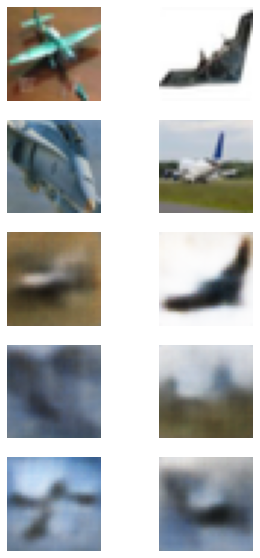

Epoch 34/50 Batch 0000/624, Loss 1770.0142


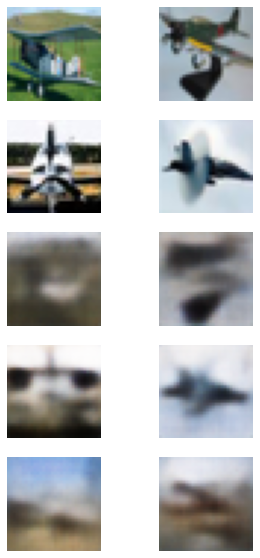

Epoch 35/50 Batch 0000/624, Loss 1807.3317


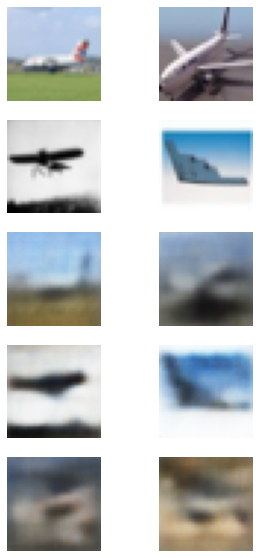

Epoch 36/50 Batch 0000/624, Loss 1820.7158


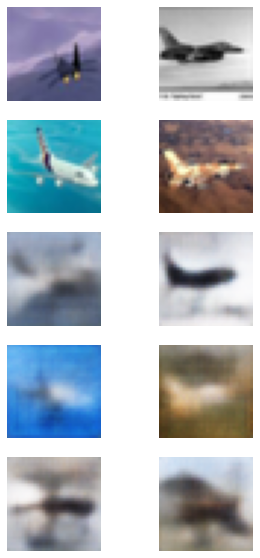

Epoch 37/50 Batch 0000/624, Loss 1763.1091


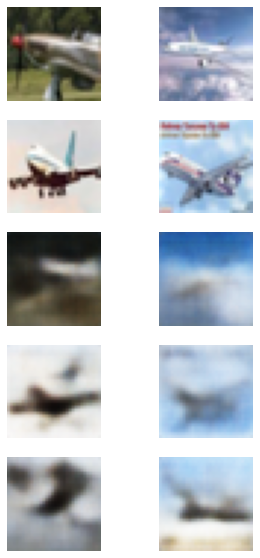

Epoch 38/50 Batch 0000/624, Loss 1638.8177


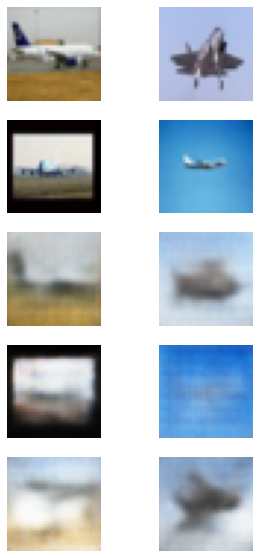

Epoch 39/50 Batch 0000/624, Loss 1802.4917


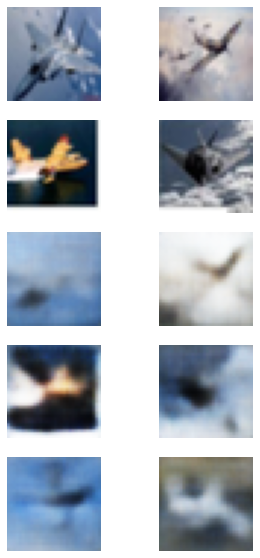

Epoch 40/50 Batch 0000/624, Loss 1859.6628


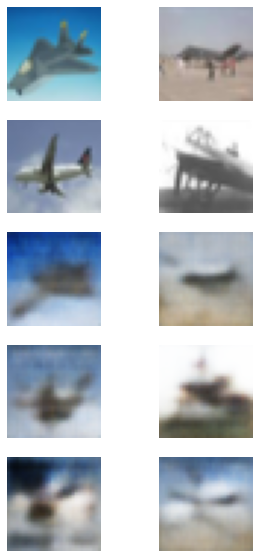

Epoch 41/50 Batch 0000/624, Loss 1816.2415


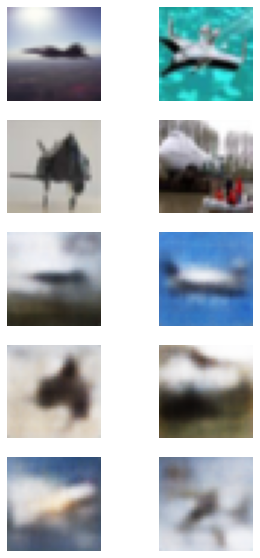

Epoch 42/50 Batch 0000/624, Loss 1841.1268


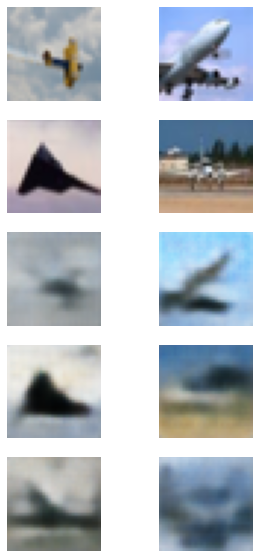

Epoch 43/50 Batch 0000/624, Loss 1854.4647


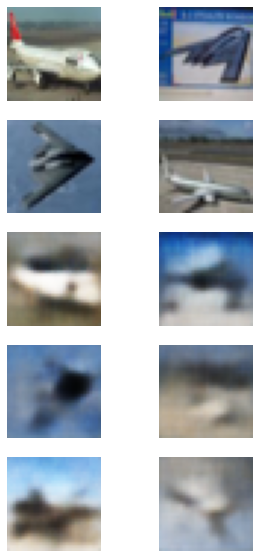

Epoch 44/50 Batch 0000/624, Loss 1920.0145


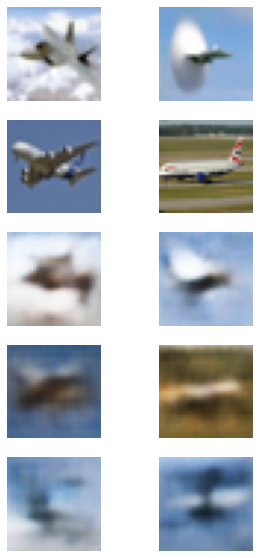

Epoch 45/50 Batch 0000/624, Loss 1864.8964


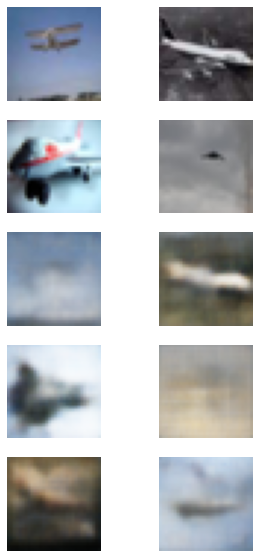

Epoch 46/50 Batch 0000/624, Loss 1750.8228


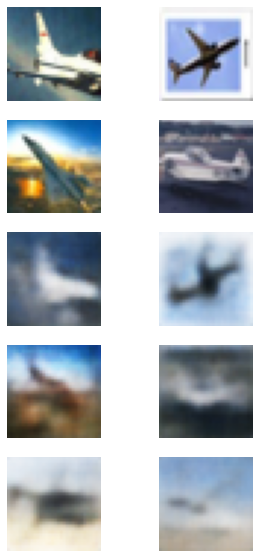

Epoch 47/50 Batch 0000/624, Loss 1718.5986


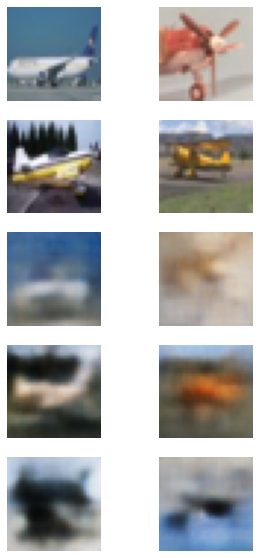

KeyboardInterrupt: ignored

In [31]:
%cd /content/drive/MyDrive
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict

def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, 32*32*3), x.view(-1, 32*32*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (BCE + KLD) / x.size(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = VAE(
#     encoder_layer_sizes=encoder_layer_sizes,
#     latent_size=latent_size,
#     decoder_layer_sizes=decoder_layer_sizes,
#     conditional=conditional,
#     num_labels=n_labels if conditional else 0).to(device)

def get_recon(models,X,Y) :
    recons = []
    for k in range(X.shape[0]) :
        recon,_,_,_ = models[Y[k]](X[k:(k+1)])
        recons.append(recon)
    recons = torch.cat(recons)
    return recons

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)


ts = time.time()

# dataset = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)
data_loader = DataLoader(
    dataset=test_dataset_raw, batch_size=batch_size, shuffle=True)

# data_loader = test_loader


logs = defaultdict(list)
for clas in range(10) :
    conditional = False
    model = VAE_conv(
            label='Cifar10',
            image_size=32,
            channel_num=3,
            kernel_num=128,
            z_size=128,
            conditional=False,
            n_labels=10
        ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_indices = get_same_index(train_dataset_raw.targets, clas)
    bird_set = torch.utils.data.Subset(train_dataset_raw, train_indices)
    train_loader_dash = torch.utils.data.DataLoader(dataset=bird_set, shuffle=True,
                                           batch_size=batch_size, drop_last=True)
    for epoch in range(epochs):
        tracker_epoch = defaultdict(lambda: defaultdict(dict))
        for iteration, (x, y) in enumerate(train_loader_dash):
            x, y = x.to(device), y.to(device)
            # print(x.shape)
            if conditional:
                recon_x, mean, log_var, z = model(x, y)
            else:
                recon_x, mean, log_var, z = model(x)
            # print(recon_x.shape)
            for i, yi in enumerate(y):
                id = len(tracker_epoch)
                tracker_epoch[id]['x'] = z[i, 0].item()
                tracker_epoch[id]['y'] = z[i, 1].item()
                tracker_epoch[id]['label'] = yi.item()

            loss = loss_fn(recon_x, x, mean, log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            logs['loss'].append(loss.item())

            if iteration % 600 == 0 or iteration == len(data_loader)-1:
                print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                    epoch, epochs, iteration, len(data_loader)-1, loss.item()))
                torch.save(model.state_dict(), 'curr_big'+str(clas)+'.pt')
                if conditional:
                    c = torch.arange(0, n_labels).long().unsqueeze(1).to(device)
                    z = torch.randn([c.size(0), 128]).to(device)
                    x = model.inference(z, c=c)
                else:
                    z_dash = torch.randn([10, 128]).to(device)
                    z_dash[4:8,:] = z[:4,:]
                    x_dash = model.inference(z_dash)
                    x_dash[:4,:,:,:] = x[:4,:,:,:]

                # plt.figure()
                plt.figure(figsize=(5, 10))
                for p in range(10):
                    plt.subplot(5, 2, p+1)
                    if conditional:
                        plt.text(
                            0, 0, "c={:d}".format(c[p].item()), color='black',
                            backgroundcolor='white', fontsize=8)
                    plt.imshow(x_dash[p].view(3,32,32).permute(1,2,0).cpu().data.numpy())
                    plt.axis('off')
                plt.show()
                # plt.clf()
                # plt.close('all')

        df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
        # g = sns.lmplot(
        #     x='x', y='y', hue='label', data=df.groupby('label').head(100),
        #     fit_reg=False, legend=True)



# Load trained models

In [13]:
def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, 32*32*3), x.view(-1, 32*32*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (BCE + KLD) / x.size(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = VAE(
#     encoder_layer_sizes=encoder_layer_sizes,
#     latent_size=latent_size,
#     decoder_layer_sizes=decoder_layer_sizes,
#     conditional=conditional,
#     num_labels=n_labels if conditional else 0).to(device)

def get_recon(models,X,Y) :
    recons = []
    for k in range(X.shape[0]) :
        recon,_,_,_ = models[Y[k]](X[k:(k+1)])
        recons.append(recon)
    recons = torch.cat(recons)
    return recons

models = []
avg_recon_error = []
for clas in range(10) :
    print(clas)
    model = VAE_conv(
            label='Cifar10',
            image_size=32,
            channel_num=3,
            kernel_num=128,
            z_size=128,
            conditional=False,
            n_labels=10
        ).to(device)/
    model.load_state_dict(torch.load('curr_t'+str(clas)+'.pt', map_location=torch.device('cpu')))
    models.append(model)
    train_indices = get_same_index(train_dataset_raw.targets, clas)
    bird_set = torch.utils.data.Subset(train_dataset_raw, train_indices)
    train_loader_dash = torch.utils.data.DataLoader(dataset=bird_set, shuffle=True,
                                           batch_size=128, drop_last=True)
    for iteration, (x, y) in enumerate(train_loader_dash):
        x, y = x.to(device), y.to(device)
        x_dash,_,_,_ = model(x)
        avg_recon_error.append(torch.nn.functional.binary_cross_entropy(
        x_dash.view(-1, 32*32*3), x.view(-1, 32*32*3),reduction='mean').detach().cpu().numpy())
        break
avg_recon_error = torch.tensor(np.array(avg_recon_error)).unsqueeze(1).to(device)
print(avg_recon_error)

0
1
2
3
4
5
6
7
8
9
tensor([[0.5579],
        [0.5601],
        [0.5947],
        [0.5593],
        [0.6058],
        [0.5739],
        [0.5855],
        [0.5755],
        [0.5806],
        [0.5642]], device='cuda:0')


# Experiments

In [23]:
# Experiments

np.random.seed(1)
torch.manual_seed(1)
import matplotlib.pyplot as plt

types = ['normal','random','fgsm','fgsm-L2','R-fgsm','R-fgsm-L2','BIM','BIM-L2','CW','S-BIM']          
data_loader = DataLoader(
    dataset=test_dataset_raw, batch_size=16, shuffle=True)

recons_errors = {}
no_of_incorrects = {}
no_of_corrects = {}
curr_i = {}
for t in types :
  recons_errors[t] = np.zeros(16*len(data_loader))
  no_of_incorrects[t] = 0
  no_of_corrects[t] = 0
  curr_i[t] = 0
model.eval()
epsilon = 20/255
epsilon_step = 4/255

epsilon1 = 500/255
epsilon_step1 = 60/255
sigma = 0.5
no_of_iters = 12
no_of_iters1 = 12
epsilon_random = 2/255

epsilon = 20/255
epsilon_step = 4/255
sigma = 0.5
no_of_iters = 12
epsilon_random = 4/255

for iteration, (x, y) in enumerate(tqdm(data_loader,position=0,leave=True)):
    x, y = x.to(DEVICE), y.to(DEVICE)
    for t in types :
        if t == 'normal' :
          x_type = x
        if t == 'random' :
          x_type = random(x,epsilon)
        if t == 'fgsm' :
          x_type = fgsm(model_raw,x,y,epsilon)
        if t == 'fgsm-L2' :
          x_type = fgsm_L2(model_raw,x,y,epsilon1)
        if t == 'R-fgsm' :
          x_type = R_fgsm(model_raw,x,y,epsilon,epsilon_random)
        if t == 'R-fgsm-L2' :
          x_type = R_fgsm_L2(model_raw,x,y,epsilon1,epsilon_random)
        if t == 'BIM' :
          x_type = BIM(model_raw,x,y,epsilon,epsilon_step,no_of_iters)
        if t == 'BIM-L2' :
          x_type = BIM_L2(model_raw,x,y,epsilon1,epsilon_step1,no_of_iters)
        if t == 'CW' :
          rands = torch.randint(0,9,(x.shape[0],)).to(DEVICE)
          x_type = CW(model_raw,x,y,epsilon,epsilon_step,no_of_iters,2,(rands<y)*rands + (rands>=y)*(rands+1)) 
        if t == 'S-BIM' :
          rands = torch.randint(0,9,(x.shape[0],)).to(DEVICE)
          x_type = S_BIM(model_raw,models,x,(rands<y)*rands + (rands>=y)*(rands+1),epsilon,sigma,epsilon_step,no_of_iters)

        y_type = torch.argmax(model_raw(x_type),1)
        no_of_incorrects[t] += torch.sum((y_type!=y))
        no_of_corrects[t] += torch.sum((y_type==y))
        if t!='normal' and t!='random' :
            indexes = (y_type!=y).nonzero()
            x_type = x_type[indexes[:,0],:,:,:]
            y_type = y_type[indexes[:,0]]
        if x_type.shape[0]!=0:
            recon_x_type = get_recon(models,x_type, y_type)
            recons_errors[t][curr_i[t]:(curr_i[t]+x_type.shape[0])] = torch.mean((recon_x_type.detach().view(-1, 32*32*3)-x_type.detach().view(-1, 32*32*3))**2).cpu().numpy()
            curr_i[t] += x_type.shape[0]
    # break

for t in types :
    recons_errors[t] = recons_errors[t][:curr_i[t]]

types =         ['normal','random','fgsm' ,'fgsm-L2','R-fgsm','R-fgsm-L2','BIM'   ,'BIM-L2','CW'  ,'S-BIM']          
type_colors_l = ['blue'  ,'red'   ,'brown','yellow' ,'green' ,'purple'   ,'orange','violet','grey','pink' ]
itr = 0
type_color = {}
for t in types :
  type_color[t] = type_colors_l[itr]
  itr += 1 

# np.savetxt('recons_errors.txt',recons_errors)
import pickle
geeky_file = open('recons_errors.txt', 'wb')
pickle.dump(recons_errors, geeky_file)
geeky_file.close()

100%|██████████| 625/625 [25:24<00:00,  2.44s/it]


Ratio for normal :  tensor(0.0892, device='cuda:0')
No of corrects for normal :  tensor(9108, device='cuda:0')
Ratio for random :  tensor(0.1044, device='cuda:0')
No of corrects for random :  tensor(8956, device='cuda:0')
Ratio for fgsm :  tensor(0.4671, device='cuda:0')
No of corrects for fgsm :  tensor(5329, device='cuda:0')
Ratio for fgsm-L2 :  tensor(0.4554, device='cuda:0')
No of corrects for fgsm-L2 :  tensor(5446, device='cuda:0')
Ratio for R-fgsm :  tensor(0.4826, device='cuda:0')
No of corrects for R-fgsm :  tensor(5174, device='cuda:0')
Ratio for R-fgsm-L2 :  tensor(0.4765, device='cuda:0')
No of corrects for R-fgsm-L2 :  tensor(5235, device='cuda:0')
Ratio for BIM :  tensor(0.9981, device='cuda:0')
No of corrects for BIM :  tensor(19, device='cuda:0')
Ratio for BIM-L2 :  tensor(0.9281, device='cuda:0')
No of corrects for BIM-L2 :  tensor(719, device='cuda:0')
Ratio for CW :  tensor(1., device='cuda:0')
No of corrects for CW :  tensor(0, device='cuda:0')
Ratio for S-BIM :  te

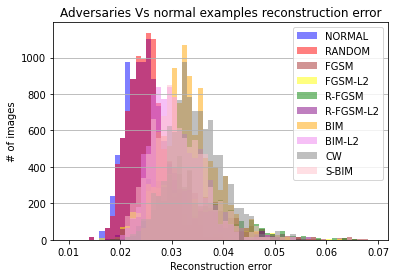

In [24]:
# types = ['normal','S-BIM'] 
import matplotlib.pyplot as plt
# ref = []

# for iteration, (x, y) in enumerate(tqdm(train_loader,position=0,leave=True)):
#     x_type, y = x.to(device), y.to(device)
#     y_type = torch.argmax(model_raw(x_type),1)
#     recon_x_type = get_recon(models,x_type, y_type)
#     ref.append((torch.mean((recon_x_type.detach().view(-1, 32*32*3)-x_type.detach().view(-1, 32*32*3))**2,dim=1)))

# ref = torch.cat(ref,dim=0).cpu().numpy()
# n, bins, patches = plt.hist(x=ref, bins = np.arange(0.0,0.08,0.001) , color='brown',
#                               alpha=0.5,label='train images')
types =         ['normal','random','fgsm' ,'fgsm-L2','R-fgsm','R-fgsm-L2','BIM'   ,'BIM-L2','CW'  ,'S-BIM']          

for t in types :
  n, bins, patches = plt.hist(x=recons_errors[t], bins = np.arange(0.01,0.07,0.001) , color=type_color[t],
                              alpha=0.5,label=t.upper())
  print("Ratio for " + t + " : ", no_of_incorrects[t]/(no_of_incorrects[t] + no_of_corrects[t]))
  print("No of corrects for " + t + " : ", no_of_corrects[t])

plt.grid(axis='y')
# size = plt.get_size_inches()*plt.dpi
# print(size)
plt.xlabel('Reconstruction error')
plt.ylabel('# of images')
plt.legend()
plt.title('Adversaries Vs normal examples reconstruction error')
plt.savefig('recons-errors.png')
maxfreq = n.max()
plt.show()

100%|██████████| 625/625 [00:33<00:00, 18.83it/s]


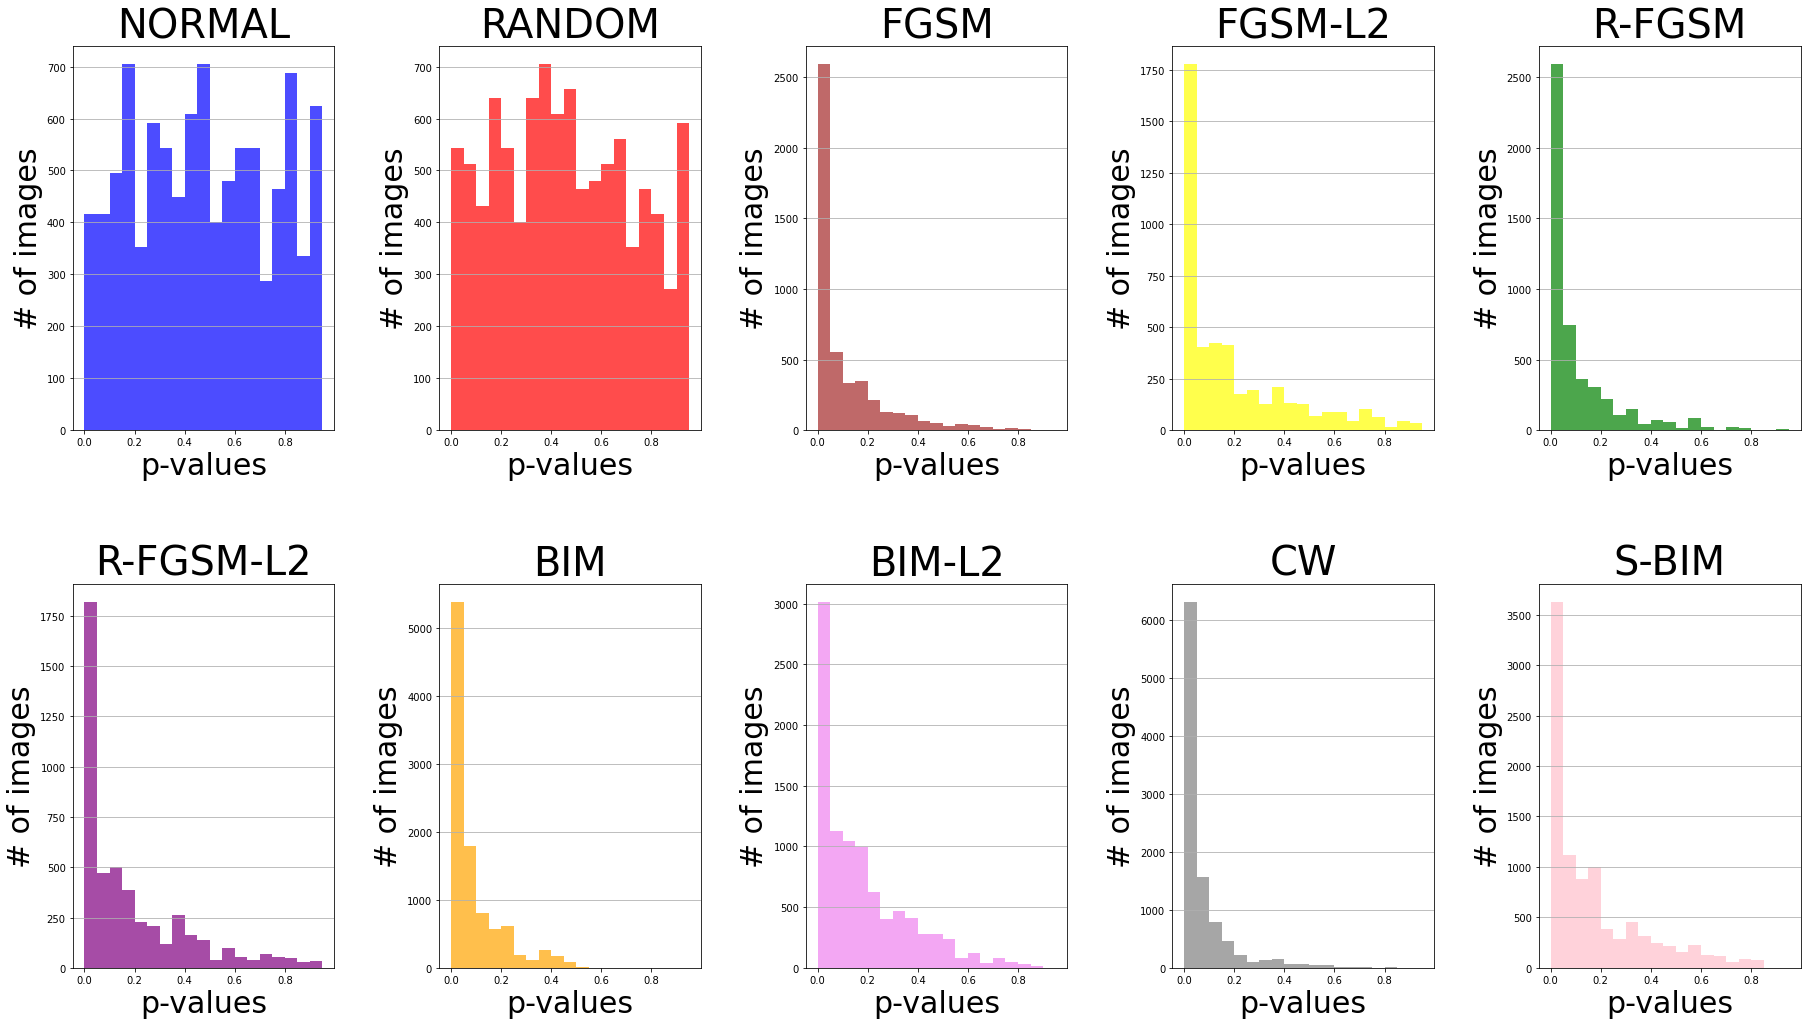

In [25]:
ref = []
for iteration, (x, y) in enumerate(tqdm(data_loader,position=0,leave=True)):
    x_type, y = x.to(device), y.to(device)
    y_type = torch.argmax(model_raw(x_type),1)
    recon_x_type = get_recon(models,x_type, y_type)
    ref.append((torch.mean((recon_x_type.detach().view(-1, 32*32*3)-x_type.detach().view(-1, 32*32*3))**2)).cpu().numpy())

# ref = torch.cat(ref,dim=0).cpu().numpy()
pvals = {}
# ref = np.array(recons_errors['normal'])
# types = ['normal','random','fgsm','fgsm','fgsmR','fgsmR','BIM','fgsmI','CW','CW']          
for t in types :
  pvals[t] = []
  for error in recons_errors[t] :
    val = np.sum(ref>error)/len(ref)#.shape[0]
    pvals[t].append(val)

plt.figure(figsize=(30, 16))
plt.tight_layout()
p = 0
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for t in types :
  p += 1
  plt.subplot(2, 5, p)
  n, bins, patches = plt.hist(x=pvals[t], bins=np.arange(0.,1.,0.05), color=type_color[t],
                              alpha=0.7)
  plt.title(t.upper(),fontsize = 40)
  plt.grid(axis='y')
  plt.xlabel('p-values',fontsize = 30)
  plt.ylabel('# of images',fontsize = 30)

plt.savefig('p-values.png')
plt.show()  


AUC for normal:  0.49362048000000014
AUC for random:  0.5220454400000001
AUC for fgsm:  0.8909340184114751
AUC for fgsm-L2:  0.7963659200702679
AUC for R-fgsm:  0.8942980522171572
AUC for R-fgsm-L2:  0.8064866316894019
AUC for BIM:  0.9116540627191664
AUC for BIM-L2:  0.8186978989333046
AUC for CW:  0.9265792
AUC for S-BIM:  0.8235388486140726


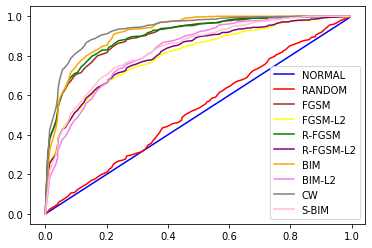

In [26]:
from sklearn import metrics
tpr = {}
for t in types :
  tpr[t] = []
  pvals[t] = np.array(pvals[t])
  # auc = 0
  fpr = []
  for pval in np.arange(0,1.01,0.01) :
    tpr[t].append(np.sum(pvals[t]<pval)/pvals[t].shape[0])
    # auc += np.sum(pvals[t]<pval)/pvals[t].shape[0]*0.01

  
  auc = metrics.auc(tpr['normal'], tpr[t])#auc - 0.5*(np.sum(pvals[t]<0)/pvals[t].shape[0]-np.sum(pvals[t]<1)/pvals[t].shape[0])*0.01
  plt.plot(tpr['normal'],tpr[t],color=type_color[t],label=t.upper())
  print("AUC for " + t + ": ", str(auc))

plt.legend()
plt.savefig('linear_comparison.png')
plt.show()

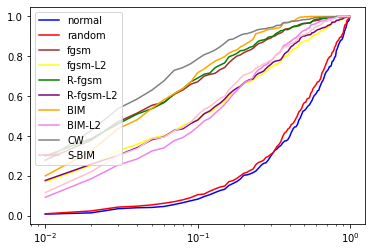

In [27]:
tpr = {}
for t in types :
  tpr[t] = []
  pvals[t] = np.array(pvals[t])
  for fpr in np.arange(0.01,1,0.01) :
    tpr[t].append(np.sum(pvals[t]<fpr)/pvals[t].shape[0])
  plt.plot(np.arange(0.01,1,0.01),tpr[t],color=type_color[t],label=t)

# types = ['normal','random','fgsm','fgsm-L2','R-fgsm','R-fgsm-L2','BIM','BIM-L2','CW','target_CW2']          

plt.legend()
plt.xscale('log')
plt.savefig('log_comparison.png')
plt.show()

# Test cases

  0%|          | 0/500 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


normal automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fgsm airplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fgsm-L2 airplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


R-fgsm airplane
R-fgsm-L2 airplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BIM airplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BIM-L2 bird


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CW airplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/500 [00:19<?, ?it/s]

S-BIM airplane


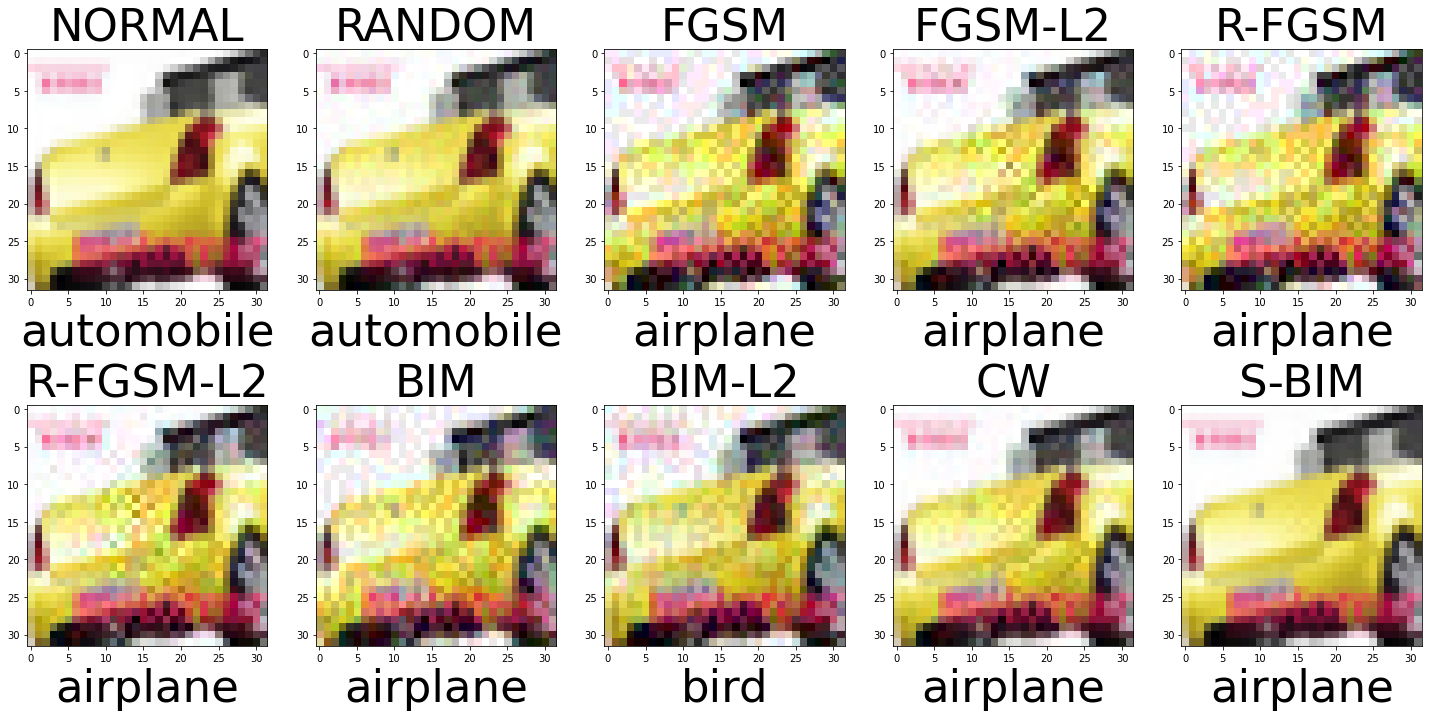

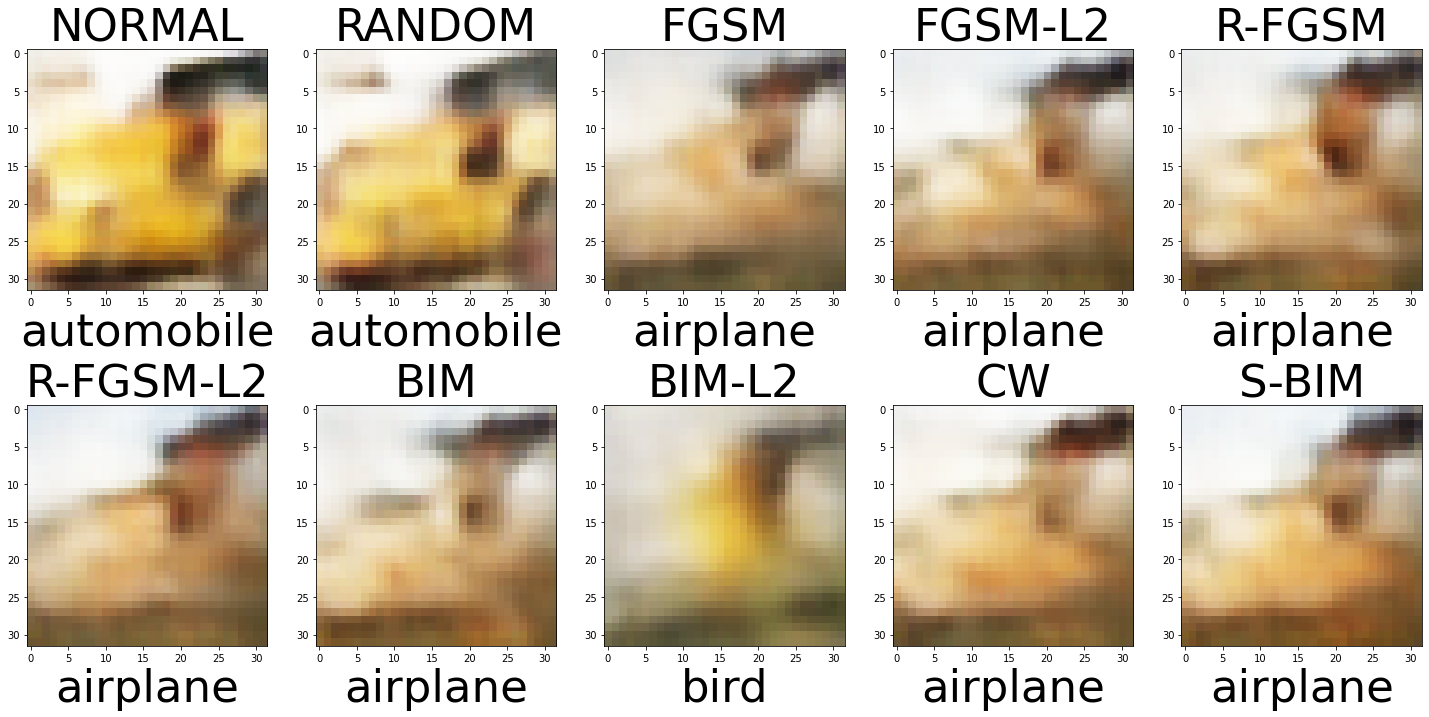

In [ ]:
types = ['normal','random','fgsm','fgsm-L2','R-fgsm','R-fgsm-L2','BIM','BIM-L2','CW','S-BIM']          
# epsilon= 0.03
reconstructeds = []
ys = []
epsilon = 20/255
epsilon_step = 4/255
sigma = 0.5
no_of_iters = 12
epsilon_random = 4/255
# 15, 23
torch.random.manual_seed(23)
plt.figure(figsize=(25, 12))
# torch.set_seed()
plt.tight_layout()
titles = []
titles2 = []
for iteration, (x, y) in enumerate(tqdm(train_loader,position=0,leave=True)):
    # print("yes")
    x, y = x.to(device), y.to(device)
    p = 0
    for t in types :
        p += 1
        if t == 'normal' :
          x_type = x
        if t == 'random' :
          x_type = random(x,epsilon/2)
        if t == 'fgsm' :
          x_type = fgsm(model_raw,x,y,epsilon)
        if t == 'fgsm-L2' :
          x_type = fgsm_L2(model_raw,x,y,25*epsilon)
        if t == 'R-fgsm' :
          x_type = R_fgsm(model_raw,x,y,epsilon,epsilon_random)
        if t == 'R-fgsm-L2' :
          x_type = R_fgsm_L2(model_raw,x,y,25*epsilon,epsilon_random)
        if t == 'BIM' :
          x_type = BIM(model_raw,x,y,epsilon,epsilon_step,no_of_iters)
        if t == 'BIM-L2' :
          x_type = BIM_L2(model_raw,x,y,25*epsilon,15*epsilon_step,no_of_iters)
        if t == 'CW' :
          rands = torch.randint(0,9,(x.shape[0],)).to(device)
          x_type = CW(model_raw,x,y,epsilon,epsilon_step,no_of_iters*2,2,(rands<y)*rands + (rands>=y)*(rands+1)) 
        if t == 'S-BIM' :
          rands = torch.randint(0,9,(x.shape[0],)).to(device)
          x_type = S_BIM(model_raw,models,x,(rands<y)*rands + (rands>=y)*(rands+1),epsilon,sigma,epsilon_step,no_of_iters)
        plt.subplot(2, 5, p)
        plt.imshow(x_type[0].permute(1,2,0)[:,:,:].cpu().data.numpy())
        y_type = torch.argmax(model_raw(x_type),1)
        titles.append(t)
        titles2.append(train_dataset_raw.classes[y_type[0]])
        plt.title(t.upper(),fontsize=45)
        # plt.axis('off')
        plt.xlabel(train_dataset_raw.classes[y_type[0]],fontsize=45)
        # if t!='normal' and t!='random':
        #     y_type = 
        recon_x_type = get_recon(models,x_type, y_type)
        print(t, train_dataset_raw.classes[y_type[0]])
        reconstructeds.append(recon_x_type[0].permute(1,2,0).cpu().data.numpy())
        # plt.savefig('orig_'+t+'.png')
        # plt.show()
    break
plt.savefig('orig_eg.png')
plt.show()

plt.figure(figsize=(25, 12))
for i in range(len(reconstructeds)) :
    plt.subplot(2, 5, i+1)
    plt.imshow(reconstructeds[i][:,:,:])
    plt.title(titles[i].upper(),fontsize=45)
    # plt.axis('off')
    plt.xlabel(titles2[i],fontsize=45)
# print('recon_eg.png')
plt.savefig('recon_eg.png')
plt.show()